# Generation of message and key

In [1]:
from random import randint

def generate_random():
    a = []
    for i in range(4):
        a.append(randint(0, 1))
    return a;

In [2]:
message = generate_random()
key = generate_random()
encrypted_message = []
for i in range(4):
    encrypted_message.append(message[i] ^ key[i])
decrypted_message = []
for i in range(4):
    decrypted_message.append(encrypted_message[i] ^ key[i])
print("Original message", "".join(map(str, message)))
print("Secret key:", "".join(map(str, key)))
print("Encrypted message:", "".join(map(str, encrypted_message)))
print("Decrypted message:", "".join(map(str, decrypted_message)))

Original message 0001
Secret key: 0011
Encrypted message: 0010
Decrypted message: 0001


# Grover's algorithm

In [3]:
from IPython.display import clear_output

In [4]:
!pip install qiskit
!pip install qiskit-aer
clear_output()

We know the original and encrypted message, as well as the algorithm for receiving it, so we need to find the key

**Notation: (what do qubits encode)** \
$k_0, ..., k_3$ - bits of the secret key (target solution) \
$m_0, ..., m_3$ - bits of the original message \
$em_0, ..., em_3$ - bits of the encrypted message \
$out_0$ - qubit used for phase conversion in Grover's algorithm

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

key_qubits = QuantumRegister(4, name='k')
message_qubits = QuantumRegister(4, name='m')
e_message_qubits = QuantumRegister(4, name='em')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(key_qubits, message_qubits, e_message_qubits, output_qubit, cbits)

Let's initialize the qubits $k_i$ of our future solution, qubit $out_0$ and qubits $m_i$ of the origin message

In [6]:
# initialization of solution qubits
def initialize(qc, qubits):
    for q in qubits:
        qc.h(q)

In [7]:
initialize(qc, key_qubits)

# converting the out_0 qubit to the "-" state
qc.x(output_qubit)
qc.h(output_qubit)

# initialization of message qubits
for i,m in enumerate(message_qubits):
    if (message[i] == 1):
        qc.x(m)

qc.barrier()
qc.draw()

┌───┐      ░ 
    k_0: ┤ H ├──────░─
         ├───┤      ░ 
    k_1: ┤ H ├──────░─
         ├───┤      ░ 
    k_2: ┤ H ├──────░─
         ├───┤      ░ 
    k_3: ┤ H ├──────░─
         └───┘      ░ 
    m_0: ───────────░─
                    ░ 
    m_1: ───────────░─
                    ░ 
    m_2: ───────────░─
         ┌───┐      ░ 
    m_3: ┤ X ├──────░─
         └───┘      ░ 
   em_0: ───────────░─
                    ░ 
   em_1: ───────────░─
                    ░ 
   em_2: ───────────░─
                    ░ 
   em_3: ───────────░─
         ┌───┐┌───┐ ░ 
    out: ┤ X ├┤ H ├─░─
         └───┘└───┘ ░ 
cbits: 4/═════════════

We need an oracle that will change the sign only of the solution we need. \
With several applications of CNOT, it is possible to implement the XOR operation between k and m qubits ($m_i \oplus k_i=em_i$), and the necessary phase shift using the encrypted message we know, CCCCNOT and the out qubit

In [8]:
# o and o+
def o_and_o_adj(qc, k_qubits, m_qubits, em_qubits):
    # xor - 1 if m_i and k_i are different,
    # if they match (X is either not applied or applied twice - X*X=I)
    for i in range(4):
        qc.cx(m_qubits[i], em_qubits[i])
        qc.cx(k_qubits[i], em_qubits[i])

In [9]:
# we know the encrypted message, in those i where 0 we apply X,
# so that the phase changes when applying CCCCNOT only for the correct answer
def real_ans(e_message_qubits):
    for i,em in enumerate(e_message_qubits):
        if (encrypted_message[i] == 0):
            qc.x(em)

In [10]:
def oracle(qc, k_qubits, m_qubits, em_qubits, out):
    o_and_o_adj(qc, key_qubits, message_qubits, e_message_qubits) # o

    # knowing the encrypted message
    real_ans(e_message_qubits)
    qc.mcx(e_message_qubits, output_qubit)
    real_ans(e_message_qubits) # +

    o_and_o_adj(qc, key_qubits, message_qubits, e_message_qubits) # o+

In [11]:
oracle(qc, key_qubits, message_qubits, e_message_qubits, output_qubit)
qc.barrier()
qc.draw()

┌───┐      ░                                                        »
    k_0: ┤ H ├──────░───────────────────────■────────────────────────────────»
         ├───┤      ░                       │                                »
    k_1: ┤ H ├──────░───────────────────────┼────■───────────────────────────»
         ├───┤      ░                       │    │                           »
    k_2: ┤ H ├──────░───────────────────────┼────┼────■──────────────────────»
         ├───┤      ░                       │    │    │                      »
    k_3: ┤ H ├──────░───────────────────────┼────┼────┼────■─────────────────»
         └───┘      ░                       │    │    │    │                 »
    m_0: ───────────░───■───────────────────┼────┼────┼────┼─────────────────»
                    ░   │                   │    │    │    │                 »
    m_1: ───────────░───┼────■──────────────┼────┼────┼────┼─────────────────»
                    ░   │    │              │    │    │    │                 »
    m_2: ───────────░───┼────┼────■─────────┼────┼────┼────┼─────────────────»
         ┌───┐      ░   │    │    │         │    │    │    │                 »
    m_3: ┤ X ├──────░───┼────┼────┼────■────┼────┼────┼────┼─────────────────»
         └───┘      ░ ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  ┌───┐     ┌───┐»
   em_0: ───────────░─┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──┤ X ├──■──┤ X ├»
                    ░ └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │  ├───┤  │  ├───┤»
   em_1: ───────────░──────┤ X ├──┼────┼───────┤ X ├──┼────┼──┤ X ├──■──┤ X ├»
                    ░      └───┘┌─┴─┐  │       └───┘┌─┴─┐  │  └───┘  │  └───┘»
   em_2: ───────────░───────────┤ X ├──┼────────────┤ X ├──┼─────────■───────»
                    ░           └───┘┌─┴─┐          └───┘┌─┴─┐┌───┐  │  ┌───┐»
   em_3: ───────────░────────────────┤ X ├───────────────┤ X ├┤ X ├──■──┤ X ├»
         ┌───┐┌───┐ ░                └───┘               └───┘└───┘┌─┴─┐└───┘»
    out: ┤ X ├┤ H ├─░──────────────────────────────────────────────┤ X ├─────»
         └───┘└───┘ ░                                              └───┘     »
cbits: 4/════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                  ░ 
«    k_0: ───────────────────────────■─────────────░─
«                                    │             ░ 
«    k_1: ───────────────────────────┼────■────────░─
«                                    │    │        ░ 
«    k_2: ─────────────────■─────────┼────┼────────░─
«                          │         │    │        ░ 
«    k_3: ─────────────────┼─────────┼────┼────■───░─
«                          │         │    │    │   ░ 
«    m_0: ───────■─────────┼─────────┼────┼────┼───░─
«                │         │         │    │    │   ░ 
«    m_1: ───────┼────■────┼─────────┼────┼────┼───░─
«                │    │    │         │    │    │   ░ 
«    m_2: ──■────┼────┼────┼─────────┼────┼────┼───░─
«           │    │    │    │         │    │    │   ░ 
«    m_3: ──┼────┼────┼────┼────■────┼────┼────┼───░─
«           │  ┌─┴─┐  │    │    │  ┌─┴─┐  │    │   ░ 
«   em_0: ──┼──┤ X ├──┼────┼────┼──┤ X ├──┼────┼───░─
«           │  └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │   ░ 
«   em_1: ──┼───────┤ X ├──┼────┼───────┤ X ├──┼───░─
«         ┌─┴─┐     └───┘┌─┴─┐  │       └───┘  │   ░ 
«   em_2: ┤ X ├──────────┤ X ├──┼──────────────┼───░─
«         └───┘          └───┘┌─┴─┐          ┌─┴─┐ ░ 
«   em_3: ────────────────────┤ X ├──────────┤ X ├─░─
«                             └───┘          └───┘ ░ 
«    out: ─────────────────────────────────────────░─
«                                                  ░ 
«cbits: 4/═══════════════════════════════════════════
«

Aplification the amplitude of a labeled state (target solution)

In [12]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Ampl"
    return U_s

In [13]:
qc.append(diffuser(4), key_qubits)
qc.draw()

┌───┐      ░                                                        »
    k_0: ┤ H ├──────░───────────────────────■────────────────────────────────»
         ├───┤      ░                       │                                »
    k_1: ┤ H ├──────░───────────────────────┼────■───────────────────────────»
         ├───┤      ░                       │    │                           »
    k_2: ┤ H ├──────░───────────────────────┼────┼────■──────────────────────»
         ├───┤      ░                       │    │    │                      »
    k_3: ┤ H ├──────░───────────────────────┼────┼────┼────■─────────────────»
         └───┘      ░                       │    │    │    │                 »
    m_0: ───────────░───■───────────────────┼────┼────┼────┼─────────────────»
                    ░   │                   │    │    │    │                 »
    m_1: ───────────░───┼────■──────────────┼────┼────┼────┼─────────────────»
                    ░   │    │              │    │    │    │                 »
    m_2: ───────────░───┼────┼────■─────────┼────┼────┼────┼─────────────────»
         ┌───┐      ░   │    │    │         │    │    │    │                 »
    m_3: ┤ X ├──────░───┼────┼────┼────■────┼────┼────┼────┼─────────────────»
         └───┘      ░ ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │  ┌───┐     ┌───┐»
   em_0: ───────────░─┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼──┤ X ├──■──┤ X ├»
                    ░ └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │  ├───┤  │  ├───┤»
   em_1: ───────────░──────┤ X ├──┼────┼───────┤ X ├──┼────┼──┤ X ├──■──┤ X ├»
                    ░      └───┘┌─┴─┐  │       └───┘┌─┴─┐  │  └───┘  │  └───┘»
   em_2: ───────────░───────────┤ X ├──┼────────────┤ X ├──┼─────────■───────»
                    ░           └───┘┌─┴─┐          └───┘┌─┴─┐┌───┐  │  ┌───┐»
   em_3: ───────────░────────────────┤ X ├───────────────┤ X ├┤ X ├──■──┤ X ├»
         ┌───┐┌───┐ ░                └───┘               └───┘└───┘┌─┴─┐└───┘»
    out: ┤ X ├┤ H ├─░──────────────────────────────────────────────┤ X ├─────»
         └───┘└───┘ ░                                              └───┘     »
cbits: 4/════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                  ░ ┌───────┐
«    k_0: ───────────────────────────■─────────────░─┤0      ├
«                                    │             ░ │       │
«    k_1: ───────────────────────────┼────■────────░─┤1      ├
«                                    │    │        ░ │  Ampl │
«    k_2: ─────────────────■─────────┼────┼────────░─┤2      ├
«                          │         │    │        ░ │       │
«    k_3: ─────────────────┼─────────┼────┼────■───░─┤3      ├
«                          │         │    │    │   ░ └───────┘
«    m_0: ───────■─────────┼─────────┼────┼────┼───░──────────
«                │         │         │    │    │   ░          
«    m_1: ───────┼────■────┼─────────┼────┼────┼───░──────────
«                │    │    │         │    │    │   ░          
«    m_2: ──■────┼────┼────┼─────────┼────┼────┼───░──────────
«           │    │    │    │         │    │    │   ░          
«    m_3: ──┼────┼────┼────┼────■────┼────┼────┼───░──────────
«           │  ┌─┴─┐  │    │    │  ┌─┴─┐  │    │   ░          
«   em_0: ──┼──┤ X ├──┼────┼────┼──┤ X ├──┼────┼───░──────────
«           │  └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │   ░          
«   em_1: ──┼───────┤ X ├──┼────┼───────┤ X ├──┼───░──────────
«         ┌─┴─┐     └───┘┌─┴─┐  │       └───┘  │   ░          
«   em_2: ┤ X ├──────────┤ X ├──┼──────────────┼───░──────────
«         └───┘          └───┘┌─┴─┐          ┌─┴─┐ ░          
«   em_3: ────────────────────┤ X ├──────────┤ X ├─░──────────
«                             └───┘          └───┘ ░          
«    out: ─────────────────────────────────────────░──────────
«                                                  ░          
«cbits: 4/═══════

To get an answer in the search problem we need approximately $\frac{\pi}{4} \sqrt\frac{N}{M}$ Grover iterations, where $N$ - number of elements in the search space, $N = 2^n$ (in our case $n=4$, therefore $N=16$), $M$ - number of solutions (1 - the required key). \
Then 3 repetitions are needed to solve our problem.

In [14]:
# 2 more left
for i in range(2):
    oracle(qc, key_qubits, message_qubits, e_message_qubits, output_qubit)
    qc.append(diffuser(4), key_qubits)

# let's measure
qc.measure(key_qubits, cbits)

Finally we get the result (in qiskit the result is read from right to left)

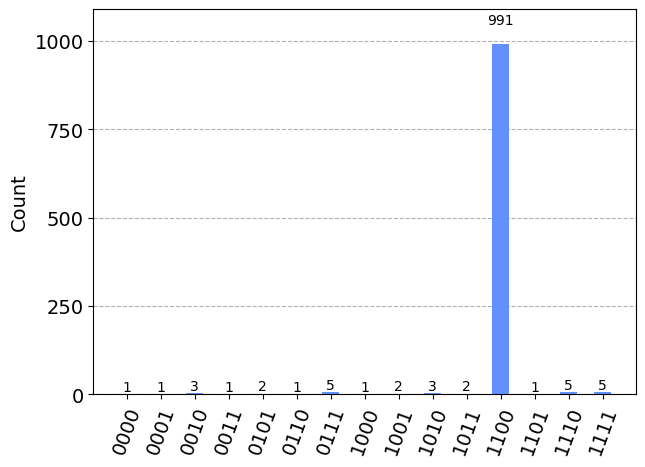

In [15]:
from qiskit import Aer, transpile

from qiskit.visualization import plot_histogram

qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

Сравним его с настоящим

In [16]:
counts = result.get_counts()
counts

{'0000': 1,
 '1100': 991,
 '1110': 5,
 '1001': 2,
 '0101': 2,
 '0010': 3,
 '1010': 3,
 '1011': 2,
 '0111': 5,
 '0011': 1,
 '1111': 5,
 '0001': 1,
 '1101': 1,
 '1000': 1,
 '0110': 1}

In [17]:
answer = (counts.most_frequent())[::-1] # to read from left to right
if (answer == "".join(map(str, key))):
    print("The secret key is calculated correctly and is equals:", answer)
else:
    print("The secret key was calculated incorrectly")

The secret key is calculated correctly and is equals: 0011
